# Rate my GU

The link to the Colab notebook is here : https://colab.research.google.com/drive/14jG44wBZrpvjLeu4RmlSU604R4Y7e9mM

In [2]:
# We first get the dataset
!wget https://github.com/DanyWind/X-AI/raw/master/lesson_2_neural_networks/data/gu-dataset_1.zip
!unzip gu-dataset_1.zip

--2019-11-11 10:35:23--  https://github.com/DanyWind/X-AI/raw/master/lesson_2_neural_networks/data/gu-dataset_1.zip
Resolving github.com (github.com)... 140.82.118.3
Connecting to github.com (github.com)|140.82.118.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/DanyWind/X-AI/master/lesson_2_neural_networks/data/gu-dataset_1.zip [following]
--2019-11-11 10:35:24--  https://raw.githubusercontent.com/DanyWind/X-AI/master/lesson_2_neural_networks/data/gu-dataset_1.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.36.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.36.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14926725 (14M) [application/zip]
Saving to: ‘gu-dataset_1.zip’

gu-dataset_1.zip    100%[===================>]  14.23M  76.7MB/s    in 0.2s    

2019-11-11 10:35:25 (76.7 MB/s) - ‘gu-dataset_1.zip’ saved [14926725/14926725]


  inflating: gu-dataset/train/Non-GU/7099262345_34fda3db55_z.jpg  
  inflating: gu-dataset/train/Non-GU/7532294286_71197e31c5_z.jpg  
  inflating: gu-dataset/train/Non-GU/7827337196_7e232d4741_z.jpg  
  inflating: gu-dataset/train/Non-GU/8078589208_fe874dd314_z.jpg  
  inflating: gu-dataset/train/Non-GU/8130621052_42a3f952c3_z.jpg  
  inflating: gu-dataset/train/Non-GU/8684062064_32f63ff3f1_z.jpg  
  inflating: gu-dataset/train/Non-GU/9324710009_ab82d88de9_z.jpg  
  inflating: gu-dataset/train/Non-GU/9326530477_81b4e1c9a9_z.jpg  
  inflating: gu-dataset/train/Non-GU/9980254685_95d71ea1a2_z.jpg  
   creating: gu-dataset/valid/
   creating: gu-dataset/valid/GU/
  inflating: gu-dataset/valid/GU/18519486_1524110481007173_7267429174912714262_n.jpg  
  inflating: gu-dataset/valid/GU/18519534_708398312696556_4475659558162972374_n.jpg  
  inflating: gu-dataset/valid/GU/22204_7V8831292.jpg  
  inflating: gu-dataset/valid/GU/677-ga-gu-bicorne.jpg  
   creating: gu-dataset/valid/Non-GU/
  inflati

In [2]:
!ls

AutoDropout-Copy1.ipynb  gu-dataset	   tabular_example.ipynb
AutoDropout.ipynb	 gu-dataset_1.zip  test_clean
autodropout.py		 models		   Test_dp.ipynb
bayesian.py		 __pycache__	   text.ipynb
callbacks.py		 Rate_my_GU.ipynb  train_clean
custom_dropout.py	 README.md	   Untitled1.ipynb


In [3]:
from fastai.vision import *
from fastai.basic_data import DatasetType

def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    random.seed(seed_value) # Python
    if use_cuda: 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

random_seed(42, True)        

# Path to the dataset
PATH = Path()
gu_ds = PATH/"gu-dataset"

# We get the transforms of the images
tfms = get_transforms(do_flip=False)

# We load the dataset
data = (ImageList.from_folder(gu_ds)
       .split_by_folder()
       .label_from_folder()
       .add_test_folder()
       .transform(tfms = tfms, size = 224)
       .databunch(bs = 6))

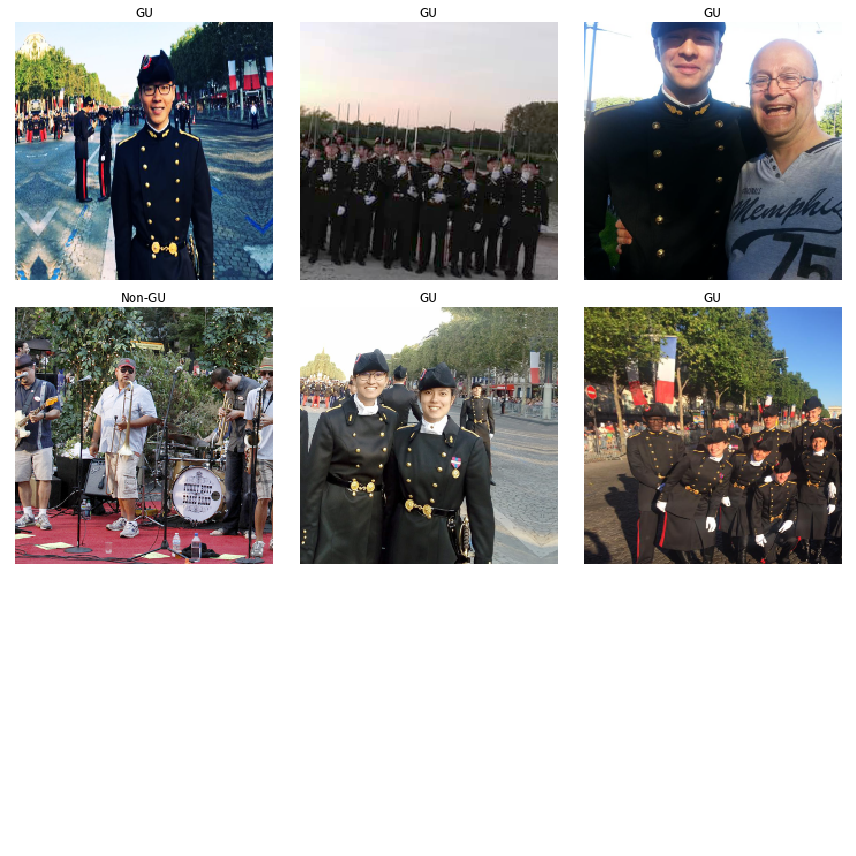

In [4]:
data.show_batch()

In [5]:
# We load the model 
learn = cnn_learner(data, models.resnet18, metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


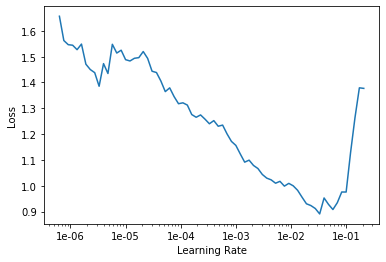

In [6]:
learn.lr_find()
learn.recorder.plot()

In [7]:
# We fit the model
learn.fit_one_cycle(2,1e-2/2)

epoch,train_loss,valid_loss,accuracy,time
0,1.002167,0.002375,1.000000,00:01
1,0.834848,0.002385,1.000000,00:01


In [8]:
from fastai_bayesian_nn.custom_dropout import CustomDropout, switch_custom_dropout, convert_layers
from fastai_bayesian_nn.bayesian import (entropy, BALD, uncertainty_best_probability,
                      get_preds_sample, plot_hist_groups, top_k_uncertainty)

In [9]:
get_args = lambda dp : {"p" : dp.p}
convert_layers(learn.model,nn.Dropout,CustomDropout,get_args)

In [10]:
switch_custom_dropout(learn.model,True,True)

Current active : True
Switching to : True
Current active : True
Switching to : True


In [22]:
pred,y = get_preds_sample(learn)
accuracy(pred.mean(dim=0),y)

tensor(1.)

In [20]:
def predict_entropy(img,n_times=10):
    pred = learn.predict_with_mc_dropout(img,n_times=n_times)
    probs = [prob[2].view((1,1) + prob[2].shape) for prob in pred]
    probs = torch.cat(probs)
    e = entropy(probs)
    return e

In [23]:
def plot_img_with_entropy(img,n_times=10):
    e = predict_entropy(img,n_times=n_times)
    img = to_np(img.data.permute(1,2,0))
    plt.imshow(img)
    plt.title(f"Entropy : {e[0]}")

In [24]:
img = open_image("night-king-compressed.jpg")

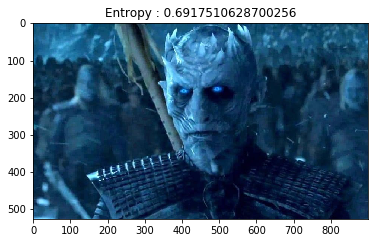

In [25]:
plot_img_with_entropy(img)

In [27]:
img = open_image(gu_ds/"train/GU/20031737_738952732974447_4800153268153117516_n.jpg")

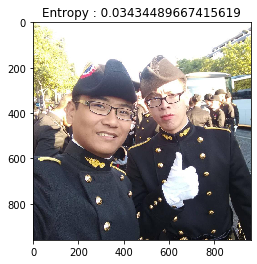

In [28]:
plot_img_with_entropy(img)